In [1]:
#imports
import numpy as np
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt

from non_layered_neural_net import nlnn



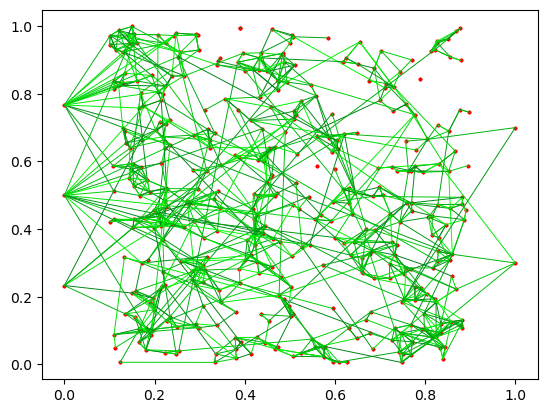

In [2]:
net = nlnn(hidden_neurons= 400, input_neurons = 3, output_neurons = 2)
net.initialise_structure(connection_probability_dropoff=3, connection_probabily_scalar=0.00003)
#net.initialise_randomly()
net.display_net()

In [13]:
#load dataset
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [14]:
#setting up conventional model 
from keras import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(3, input_shape=(28*28,), activation='sigmoid'))
#model.add(Dense(8, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])


In [15]:
#model.fit(mod_x_train, one_hot_y_train, epochs=10, batch_size=32)

In [16]:
#evaluate model
#accuracy = model.evaluate(mod_x_test, one_hot_y_test)
#print(accuracy)

In [18]:
#try on all classes
#one hot encode
def one_hot_encode(x):
    out = np.zeros((len(x), max(x)+1))
    for i in range(len(x)):
        out[i][x[i]] = 1
    return out

y_train_ohe = one_hot_encode(train_y)
y_test_ohe = one_hot_encode(test_y)
#flatten images
x_train = train_X.reshape(len(train_X), 28*28)
x_test = test_X.reshape(len(test_X), 28*28)

x_test = np.array_split(x_test, 10)
y_test_ohe = np.array_split(y_test_ohe, 10)


model_all = Sequential()
#model_all.add(Dense(3, input_shape=(28*28,), activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))
model_all.add(Dense(10, activation='softmax'))

# compile the keras model
model_all.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

model_all.fit(x_train, y_train_ohe, epochs=10, batch_size=32)

(1000, 784)
(1000, 10)
Epoch 1/10
   1/1875 [..............................] - ETA: 5:24 - loss: 63.3809 - accuracy: 0.0938

2023-03-04 18:07:08.389739: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-04 18:07:08.492436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 7s 3ms/step - loss: 5.8490 - accuracy: 0.8264
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.7819 - accuracy: 0.8504
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.6803 - accuracy: 0.8560
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.6811 - accuracy: 0.8560
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5785 - accuracy: 0.8579
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 4.6293 - accuracy: 0.8589
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5173 - accuracy: 0.8609
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5344 - accuracy: 0.8602
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5437 - accuracy: 0.8604
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5442 - accurac

In [ ]:
#evaluate model
accuracy = model.evaluate(mod_x_test, one_hot_y_test)
print(accuracy)

In [19]:
#setting up evolutionary pipeline
performance_over_time = []
#creating initial population
population_size = 12
def create_population(population_size):
    population = []
    print("Creating networks")
    for i in range(population_size):
        net = nlnn(output_neurons = 10, hidden_neurons = 1000)
        net.initialise_structure(connection_probability_dropoff=3, connection_probabily_scalar=0.00003)
        #net.initialise_randomly()
        population.append(net)
        print("|", end="")

    print("done!")
    return population


networks = create_population(population_size)

Creating networks
||||||||||||done!


In [22]:
def get_perf(t):
        return t[0]

#measure performance of all the networks
def evaluate_performance(population, x, y):
    performances = []
    print("evaluating performances", end="")
    for net in population:
        predictions = net.predict(x, 8)[0]
        correct_count = len(x)-(np.sum(np.abs(y - predictions))/2)
        performances.append((correct_count/len(x), net))
        #print(correct_count/len(x))
        print("|", end="")
    print(" done!", end=" ")
    #sort by best performance
    performances.sort(key = get_perf, reverse = True)
    return performances

evaluated_networks = evaluate_performance(networks, x_test[1], y_test_ohe[1])
print("best performer of this generation :", evaluated_networks[0][0])
performance_over_time.append(np.array(evaluated_networks)[:,0])

evaluating performances|||||||||||| done! best performer of this generation : 0.13


In [23]:
import multiprocess as mp

def evaluate_net(net):
    predictions = net.predict(x_test, 10)[0]
    correct_count = len(x_test)-(np.sum(np.abs(y_test_ohe - predictions))/2)
    return (correct_count/len(x_test), net)

def evaluate_performance_parallel(population):
    print("evaluating performances", end="")
    with mp.Pool() as pool:
        performances = pool.map(evaluate_net, population)
    print(" done!", end=" ")
    performances.sort(key = get_perf, reverse = True)
    return performances



In [24]:
#the n best performing networks will be selected
n = 3
mutation_range = 0.1

def repopulate(evaluated_networks, mutation_range, n):
    offspring_per_network = int(population_size/n)
    next_gen = [i[1] for i in evaluated_networks[:n]]
    for net in next_gen:
        next_gen = next_gen+net.reproduce(offspring_per_network, mutation_range)
    return next_gen
    
next_generation = repopulate(evaluated_networks, mutation_range,n)

In [32]:
performance_over_time = []

In [49]:
test_sets_used = []
mutation_ranges = []

In [33]:
print(np.array(performance_over_time))
for i in performance_over_time:
    print(len(i))

[]


generation 1060  test set: 6 evaluating performances|||||||||||| done!  best: 0.277 second: 0.272 third: 0.265
mutating in range: 0.33858912413033837


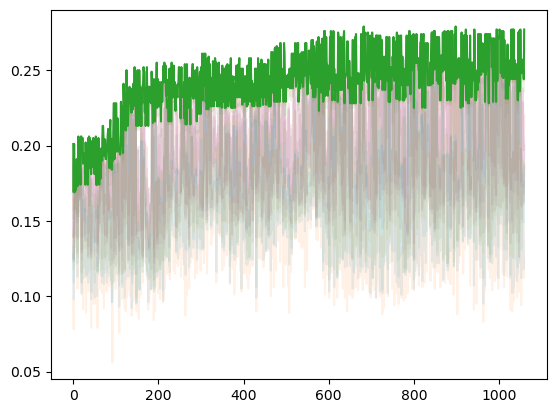

average best of last 20 generations 0.2522
generation 1061  test set: 8 evaluating performances|||||||||||| done!  best: 0.25 second: 0.248 third: 0.247
mutating in range: 0.5320804856408783
generation 1062  test set: 3 evaluating performances|||||||||||| done!  best: 0.258 second: 0.257 third: 0.253
mutating in range: 0.3779173002456683
generation 1063  test set: 3 evaluating performances|||||||||||| done!  best: 0.258 second: 0.257 third: 0.253
mutating in range: 0.8070979517027709
generation 1064  test set: 4 evaluating performances|||||||||||| done!  best: 0.244 second: 0.243 third: 0.236
mutating in range: 0.9488989059102565
generation 1065  test set: 3 evaluating performances|||||||||||| done!  best: 0.258 second: 0.257 third: 0.253
mutating in range: 0.8711610906211622
generation 1066  test set: 5 evaluating performances|||||||||||| done!  best: 0.266 second: 0.265 third: 0.262
mutating in range: 0.587301939187822
generation 1067  test set: 0 evaluating performances|||||||||||| 

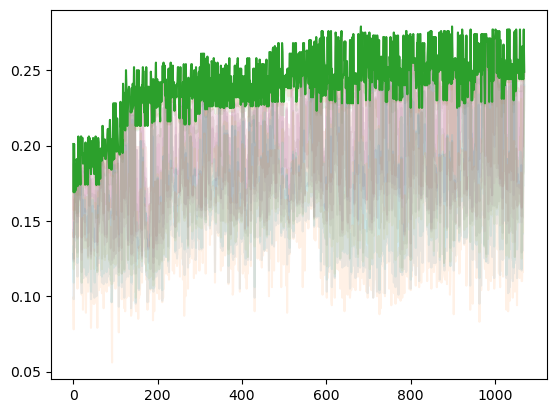

average best of last 20 generations 0.25559999999999994
generation 1071  test set: 5 evaluating performances|||||||||||| done!  best: 0.271 second: 0.271 third: 0.266
mutating in range: 0.40598321222197364
generation 1072  test set: 7 evaluating performances|||||||||||| done!  best: 0.274 second: 0.271 third: 0.267
mutating in range: 0.8310987577191739
generation 1073  test set: 6 evaluating performances|||||||||||| done!  best: 0.274 second: 0.273 third: 0.273
mutating in range: 0.5370786225031041
generation 1074  test set: 6 evaluating performances|||||||||||| done!  best: 0.274 second: 0.273 third: 0.273
mutating in range: 0.9038206905740899
generation 1075  test set: 2 evaluating performances|||||||||||| done!  best: 0.234 second: 0.234 third: 0.233
mutating in range: 0.6486925818011526
generation 1076  test set: 3 evaluating performances|||||||||||| done!  best: 0.254 second: 0.253 third: 0.252
mutating in range: 0.14198555976167337
generation 1077  test set: 6 evaluating performa

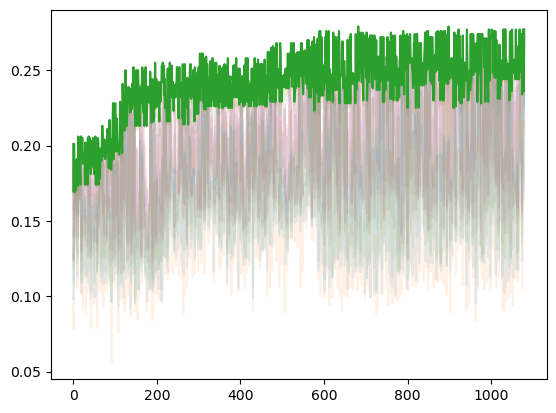

average best of last 20 generations 0.25915000000000005
generation 1081  test set: 7 evaluating performances|||||||||||| done!  best: 0.274 second: 0.269 third: 0.269
mutating in range: 0.2328787015071847
generation 1082  test set: 5 evaluating performances|||||||||||| done!  best: 0.271 second: 0.269 third: 0.267
mutating in range: 0.6749307362540942
generation 1083  test set: 7 evaluating performances|||||||||||| done!  best: 0.274 second: 0.269 third: 0.267
mutating in range: 0.7652095237771492
generation 1084  test set: 1 evaluating performances|||||||||||| done!  best: 0.239 second: 0.237 third: 0.235
mutating in range: 0.8980707688186949
generation 1085  test set: 1 evaluating performances|||||||||||| done!  best: 0.239 second: 0.237 third: 0.235
mutating in range: 0.8973195791912736
generation 1086  test set: 3 evaluating performances|||||||||||| done!  best: 0.254 second: 0.254 third: 0.253
mutating in range: 0.7812120984440504
generation 1087  test set: 4 evaluating performanc

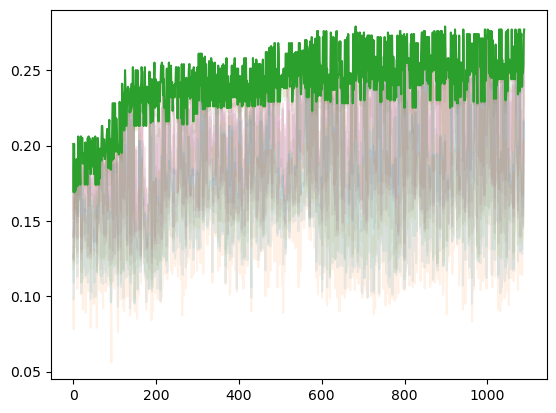

average best of last 20 generations 0.26130000000000003
generation 1091  test set: 4 evaluating performances|||||||||||| done!  best: 0.248 second: 0.245 third: 0.242
mutating in range: 0.7494254229300885
generation 1092  test set: 7 evaluating performances|||||||||||| done!  best: 0.274 second: 0.269 third: 0.269
mutating in range: 0.6161887104362085
generation 1093  test set: 2 evaluating performances|||||||||||| done!  best: 0.236 second: 0.234 third: 0.233
mutating in range: 0.8752304134572542
generation 1094  test set: 8 evaluating performances|||||||||||| done!  best: 0.251 second: 0.249 third: 0.249
mutating in range: 0.9059112172233481
generation 1095  test set: 8 evaluating performances|||||||||||| done!  best: 0.251 second: 0.249 third: 0.249
mutating in range: 0.330479670834425
generation 1096  test set: 9 evaluating performances|||||||||||| done!  best: 0.242 second: 0.241 third: 0.239
mutating in range: 0.17744405550913378
generation 1097  test set: 0 evaluating performanc

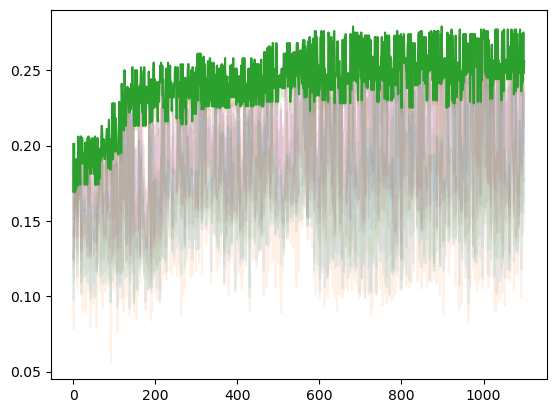

average best of last 20 generations 0.25705000000000006
generation 1101  test set: 8 evaluating performances|||||||||||| done!  best: 0.25 second: 0.249 third: 0.241
mutating in range: 0.06442609618686634
generation 1102  test set: 8 evaluating performances|||||||||||| done!  best: 0.251 second: 0.251 third: 0.25
mutating in range: 0.9329403313715089
generation 1103  test set: 9 evaluating performances|||||||||||| done!  best: 0.247 second: 0.246 third: 0.237
mutating in range: 0.5948772287358658
generation 1104  test set: 6 evaluating performances|||||||||||| done!  best: 0.276 second: 0.272 third: 0.271
mutating in range: 0.9739473975214685
generation 1105  test set: 2 evaluating performances|||||||||||| done!  best: 0.235 second: 0.234 third: 0.234
mutating in range: 0.9822493643412976
generation 1106  test set: 2 evaluating performances|||||||||||| done!  best: 0.235 second: 0.234 third: 0.234
mutating in range: 0.8516641035836578
generation 1107  test set: 6 evaluating performance

KeyboardInterrupt: 

In [48]:
generations = 5000
mutation_range = 1
population_size = 10
for gen in range(generations):
    #if(gen%10==0 and gen!=0): 
    #    mutation_range/=1.4
    #    print("decreasing mutation range from",mutation_range*1.4,"to",mutation_range)
    print("generation "+str(len(performance_over_time)+1), end=" ")
    test_set = np.random.randint(10)
    test_sets_used.append(test_set)
    print(" test set:",test_set,end=" ")
    evaluated_networks = evaluate_performance(next_generation, x_test[test_set], y_test_ohe[test_set])
    print(" best:", evaluated_networks[0][0], "second:", evaluated_networks[1][0], "third:", evaluated_networks[2][0])
    performance_over_time.append(list(np.array(evaluated_networks)[:,0]))
    generational_mutation_range = np.random.rand()*mutation_range
    mutation_ranges.append(generational_mutation_range)
    print("mutating in range:", generational_mutation_range)
    next_generation = repopulate(evaluated_networks, generational_mutation_range, n)
    if(gen%10==0):
        plt.plot(performance_over_time, alpha= 0.1)
        plt.plot(np.array(performance_over_time)[:,0])
        plt.show()
        print("average best of last 20 generations",np.average(np.array(performance_over_time)[-100:,0]))
    

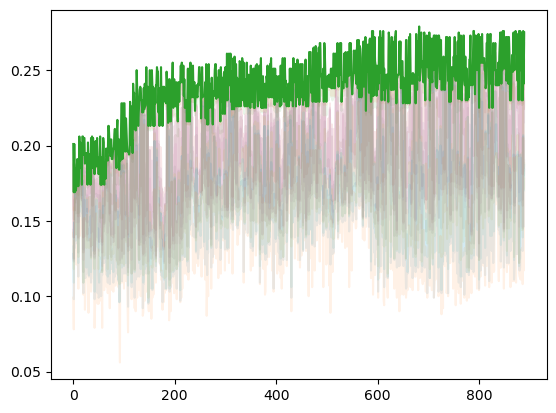

In [43]:
#TQDM -> loading bars

plt.plot(performance_over_time, alpha= 0.1)
plt.plot(np.array(performance_over_time)[:,0])
#plt.plot(list(0.99*np.ones(len(performance_over_time))))
plt.show()

In [50]:
np.savetxt('training_run_2.csv', performance_over_time, delimiter=',')

In [ ]:
#Ideas to improve GA
#take best of last 3 gens instead of best 3 of last gen